# Final Project for Applied Physics in Programming
By: Eveliina Hampus, DIN22SP

### 1. Import necessary libraries. 

Remember to install libraries with %pip install or properly via CLI with pip install.
Notice that Seaborn is depentant from Matplotlib.

In [161]:
import numpy as np # For calculations
import matplotlib.pyplot as plt # For basic plotting
import pandas as pd # For data manipulation
import folium # For interactive maps
import seaborn as sns # For more informative plots, requires matplotlib to be imported first
from scipy.signal import butter,filtfilt # For filtering
from math import radians, cos, sin, asin, sqrt #

### 2. Read the data using pandas dataframes.

You may to explore your data with few methods to get basic overview of your data. Use these with a variable assigned to your dataframe.

*.head()* prints out first 5 lines of the data, whilst *.tail()* does same for last 5 lines.
*.info()* prints out information of datatypes in the data.
*.describe()* shows basic statistics of the data. Especially min and max values are helpful in order to decide limits of your plotting graphs.

In [162]:
gps_data = pd.read_csv('GPS_data.csv') # Read the GPS data from the csv file
acc_data = pd.read_csv('Acceleration_data.csv') # Read the acceleration data from the csv file

In [163]:
gps_data.head() # Show the first 5 rows of the GPS data

,Unnamed: 0,seconds_elapsed,longitude,latitude
0,0,3.703666,25.516165,65.071375
1,1,5.339879,25.516227,65.071393
2,2,5.680000,25.516240,65.071398
3,3,6.311351,25.516264,65.071394
4,4,7.323929,25.516267,65.071396


In [164]:
acc_data.head() # Show the first 5 rows of the acceleration data

,Unnamed: 0,seconds_elapsed,z,y,x
0,0,0.143440,-2.846008,-0.581977,-0.468246
1,1,0.159217,-2.651466,-0.560432,-0.418557
2,2,0.175117,-2.132024,-0.366186,-0.535990
3,3,0.190986,-1.023350,-0.041039,-0.522485
4,4,0.206763,-0.449766,0.229015,-0.356920


### 3. Haversine formula.

In [165]:
#define haversine formula
#inputs are the coordinates of two points: lon1, lat1, lon2, lat2

def haversine(lon1, lat1, lon2, lat2):
    #convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    #calculate differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    #apply haversine formula
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    #earth radius in kilometers
    r = 6371
    #calculate the result
    return c * r

### 4. Calculate velocity from GPS data.

Teacher's example code - in pandas 3.0 chaining and slicing will become problematic. Hence this original syntax of *df["col"][row_indexer] = value* was modified to *df.loc[row_indexer, "col"] = value* instead. Calculations are made with latter.


>`lat = gps_data['latitude'] #latitude`
>`lon = gps_data['longitude'] #longitude`
>
>`gps_data['dist'] = np.zeros(lat.shape[0]) #create a new column for distance`
>`gps_data['time_diff'] = np.zeros(lat.shape[0]) #create a new column for time difference`
>
>`#calculate distance and time difference between points`
>`for i in range(lat.shape[0]-1):`
>  `  gps_data['dist'][i] = haversine(lon[i], lat[i], lon[i+1], lat[i+1])*1000 #distance in meters`
>  `  gps_data['time_diff'][i] = gps_data['seconds_elapsed'][i+1] - gps_data['seconds_elapsed'][i]`
>
>`gps_data['dist'][0] = 0 #set the first distance to zero`
>`gps_data['velocity'] = gps_data['dist']/gps_data['time_diff'] #calculate velocity`
>
>`#Print velocity`
>`gps_data['velocity']`

In [166]:
# Modified syntax

lat = gps_data['latitude'] # latitude
lon = gps_data['longitude'] # longitude

gps_data['dist'] = np.zeros(lat.shape[0]) # create a new column for distance
gps_data['time_diff'] = np.zeros(lat.shape[0]) # create a new column for time difference

# calculate distance and time difference between points
for i in range(lat.shape[0]-1):
    gps_data.loc[i, 'dist'] = haversine(lon[i], lat[i], lon[i+1], lat[i+1])*1000 # distance in meters
    gps_data.loc[i, 'time_diff'] = gps_data.loc[i+1, 'seconds_elapsed'] - gps_data.loc[i, 'seconds_elapsed']

gps_data.loc[0, 'dist'] = 0 # set the first distance to zero
gps_data['velocity'] = gps_data['dist'] / gps_data['time_diff'] # calculate velocity


In [167]:
# Print velocity
print(gps_data['velocity'])

0      0.000000
1      2.382686
2      1.855274
3      0.226845
4      0.717928
         ...   
217    1.745572
218    1.882024
219    0.925273
220    1.851229
221         NaN
Name: velocity, Length: 222, dtype: float64


### 5. Calculate total distance.

In [168]:
# calculate the total distance traveled
total_distance = gps_data['dist'].sum()

In [169]:
print('Total distance traveled: ', np.round(total_distance), 'm')

Total distance traveled:  215.0 m


### 6. Calculate total time.

In [170]:
# calculate the total time elapsed
total_time = gps_data['seconds_elapsed'].iloc[-1] - gps_data['seconds_elapsed'].iloc[0]

In [171]:
print('Total time elapsed: ', np.round(total_time), 's')

Total time elapsed:  130.0 s


### 7. Calculate average speed.

In [172]:
# calculate average speed
average_speed = total_distance / total_time

In [173]:
print('Average speed: ', np.round(average_speed), 'm/s')

Average speed:  2.0 m/s


### 8. Distance graph.

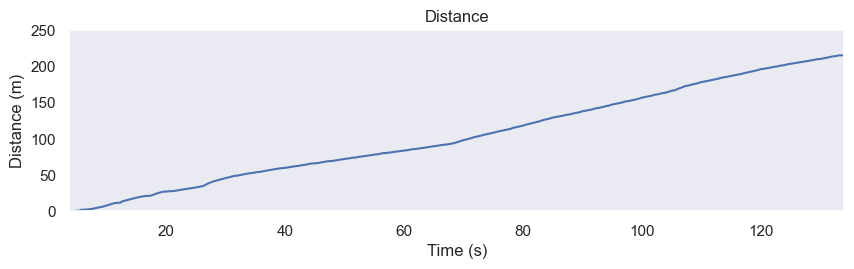

In [174]:
#Distance
plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(gps_data['seconds_elapsed'], np.cumsum(gps_data['dist'])) #Distance from GPS data
plt.grid()
plt.title('Distance')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.axis([3.7, 134, 0, 250 ])
plt.show()

### 9. Velocity graph.

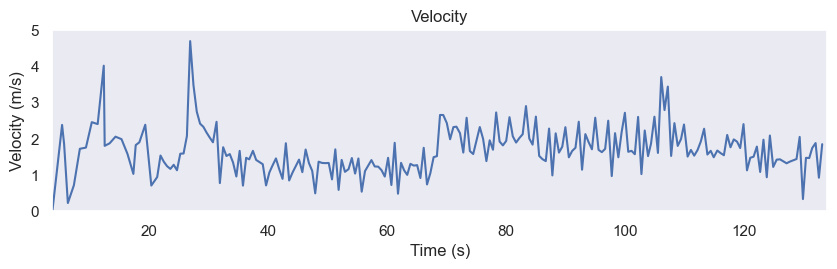

In [175]:
#Velocity
plt.figure(figsize=(10, 8))
plt.subplot(3,1,2)
plt.plot(gps_data['seconds_elapsed'], gps_data['velocity']) #Velocity from GPS data
plt.grid()
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.axis([3.7, 134 , 0, 5])
plt.show()

## Acceleration

### 10. Acceleration graph calculated from speed.
(One component)

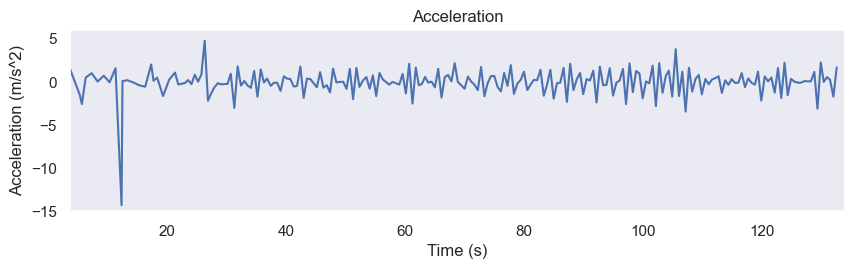

In [176]:
# Acceleration
plt.figure(figsize=(10, 8))
plt.subplot(3,1,3)
gps_data['acc'] = (gps_data['velocity'].shift(-1) - gps_data['velocity'])/gps_data['time_diff']
plt.plot(gps_data['seconds_elapsed'][:-1], gps_data['acc'][:-1])  # Exclude the last element to match the length
plt.grid()
plt.title('Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.axis([3.7, 134, -15, 6])
plt.show()

### 11. Acceleration, observed. Three components, x, y and z.

In [177]:
acc_data['x'].describe() # Descriptive statistics for the x-axis

count    8446.000000
mean       -0.371282
std         1.471625
min        -6.553377
25%        -1.198304
50%        -0.296514
75%         0.490000
max         6.245217
Name: x, dtype: float64

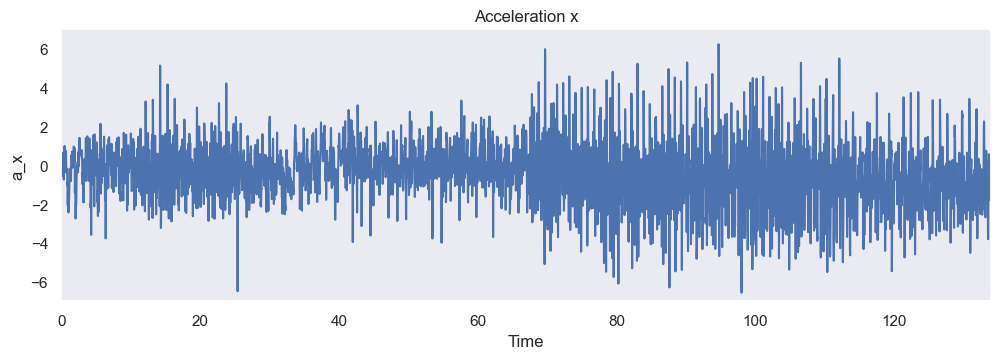

In [178]:
plt.figure(figsize=(12, 12))

# Acceleration x
plt.subplot(3, 1, 1)
plt.plot(acc_data['seconds_elapsed'], acc_data['x'])
plt.grid()
plt.title('Acceleration x')
plt.xlabel('Time')
plt.ylabel('a_x')
plt.axis([0, 134, -7, 7])

plt.show()

In [179]:
acc_data['y'].describe() # Descriptive statistics for the y-axis

count    8446.000000
mean       -0.547187
std         1.876145
min        -6.470728
25%        -1.858556
50%        -0.573834
75%         0.616766
max         6.671381
Name: y, dtype: float64

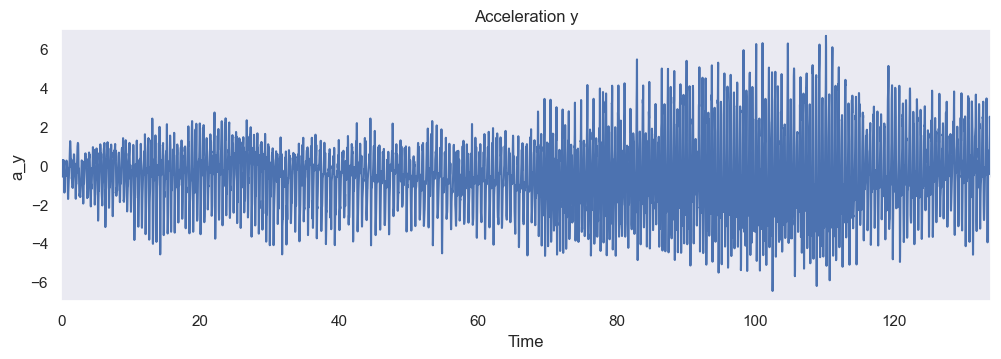

In [180]:
plt.figure(figsize=(12, 12))

# Acceleration y
plt.subplot(3, 1, 2)
plt.plot(acc_data['seconds_elapsed'], acc_data['y'])
plt.grid()
plt.title('Acceleration y')
plt.xlabel('Time')
plt.ylabel('a_y')
plt.axis([0, 134, -7, 7])

plt.show()

In [181]:
acc_data['z'].describe() # Descriptive statistics for the z-axis

count    8446.000000
mean        0.238562
std         3.771963
min        -9.976121
25%        -2.434875
50%        -0.047324
75%         2.700927
max        15.250758
Name: z, dtype: float64

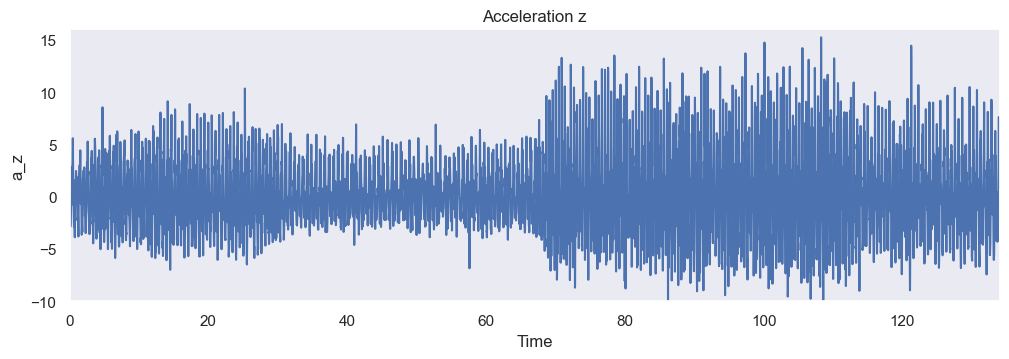

In [182]:
plt.figure(figsize=(12, 12))

# Acceleration z
plt.subplot(3, 1, 3)
plt.plot(acc_data['seconds_elapsed'], acc_data['z'])
plt.grid()
plt.title('Acceleration z')
plt.xlabel('Time')
plt.ylabel('a_z')
plt.axis([0, 134, -10, 16])

plt.show()

### 12. Introducing filters for noisy data.

In [183]:
def butter_lowpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

#Filter the data
noisy_signal = acc_data['z']
time = acc_data['seconds_elapsed']

order = 2
dt = (time[len(time)-1] - time[0])/len(time)

fs = 1/dt
nyq = 0.5 * fs
cutoff_H = 1/5 #Highpass
cutoff_L = 1/0.5 #Lowpass

#Remember to define filters
lowpass_filtered = butter_lowpass_filter(noisy_signal, cutoff_L, fs, nyq, order)
final_signal = butter_highpass_filter(lowpass_filtered, cutoff_H, fs, nyq, order)

### 13. Plotting filtered z-component acceleration data.

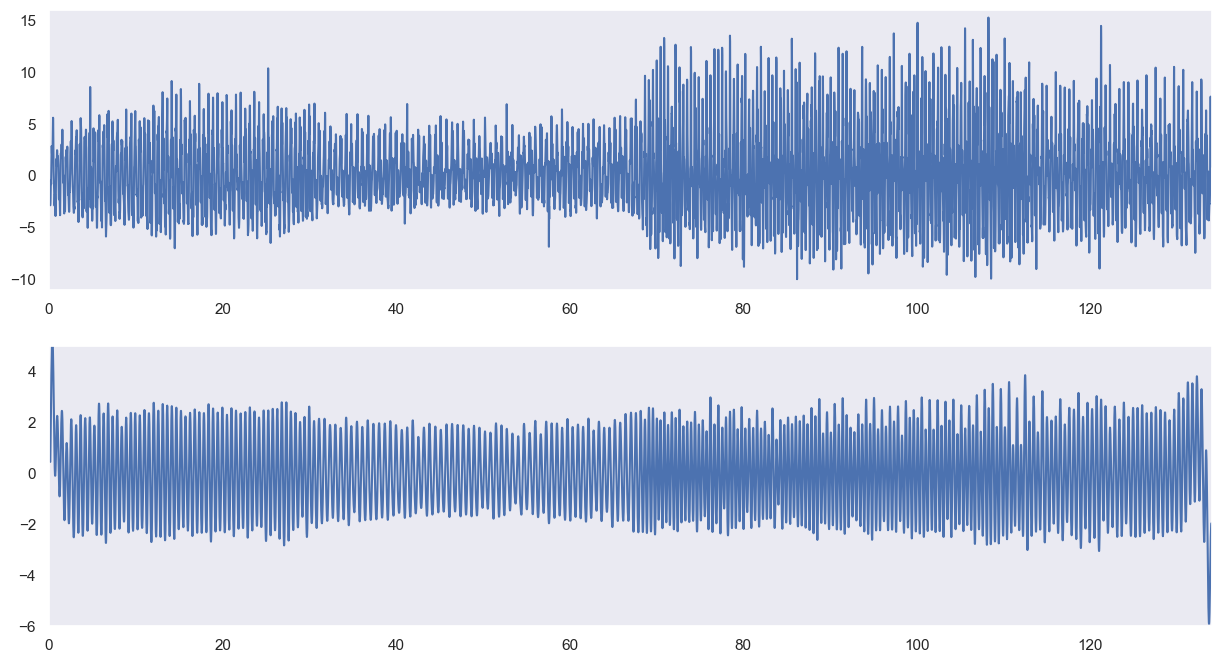

In [184]:
#Filtered z-component of acceleration

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(time, noisy_signal)
plt.grid()
plt.axis([0, 134, -11, 16])

plt.subplot(2, 1, 2)
plt.plot(time, final_signal)
plt.grid()
plt.axis([0, 134, -6, 5])
plt.show()

### 14. Visualization of acceleration components x, y, z and acceleration from speed with Seaborn.

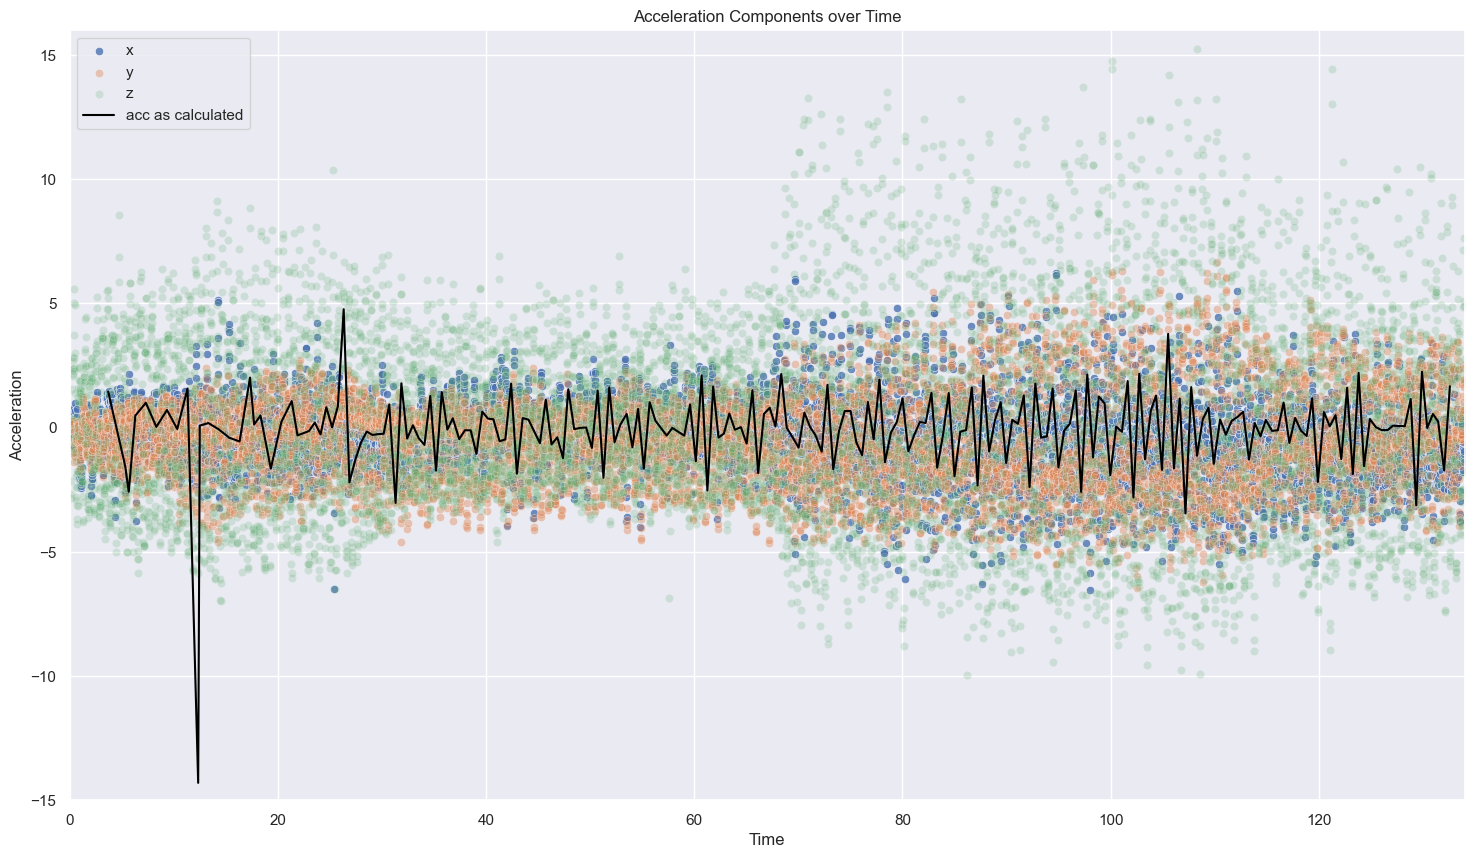

In [185]:
# Set figure size using Matplotlib
plt.figure(figsize=(18, 10))

# Create separate line plots for each acceleration component with adjusted colors and alpha values
sns.scatterplot(data=acc_data, x="seconds_elapsed", y="x", alpha=0.8, label='x')
sns.scatterplot(data=acc_data, x="seconds_elapsed", y="y", alpha=0.4, label='y')
sns.scatterplot(data=acc_data, x="seconds_elapsed", y="z", alpha=0.2, label='z')

# Plot the calculated acceleration as a separate line
sns.lineplot(data=gps_data, x="seconds_elapsed", y="acc", color='black', alpha=1, label='acc as calculated')

plt.axis([0, 134, -15, 16])
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration Components over Time')
plt.legend()
plt.show()


## Q: Does the acceleration calculated from the speed match the observed acceleration? What differences do you notice? What could be their cause?

## STEPS DATA

### 15. Calculate the steps taken.

From filtered data.

In [191]:
# Calculate the steps from filtered data
stepdata = final_signal
steps = 0
for i in range(stepdata.shape[0]-1):
    if stepdata[i]/stepdata[i+1] < 0:
        steps = steps + 0.5

In [192]:
print('The number of steps is', np.round(steps)) 

The number of steps is 256.0


From unfiltered z-component data with power spectrum/FFT method.

In [188]:
# Calculate the steps from unfiltered data with the power spectral density
t = acc_data['seconds_elapsed'] #Time
f = acc_data['z'] #Signal

def calculate_power_spectrum(f,t):
    dt = (t[len(t)-1] - t[0])/len(t)
    n = len(f)
    fft = np.fft.fft(f,n)
    PSD = fft*np.conj(fft)/n
    freq = 1/(dt*n)*np.arange(n)
    L = np.arange(1,np.floor(n/2),dtype = 'int')
    psd = np.array([freq[L],PSD[L].real])
    return psd

psd = calculate_power_spectrum(f,t) #Power spectrum

T = t[len(t)-1] - t[0] #Data interval

max_f = psd[0,np.argmax(psd[1,:])] #Most powerful frequency 
steps2 = T*max_f #Number of steps

In [189]:
print('The number of steps is', np.round(steps2,0))

The number of steps is 255.0


## Q: Is the number of steps logical?

### 16. A map of movement (Folium).

In [190]:
location_frame = gps_data[['latitude', 'longitude']]
location_list = location_frame.values.tolist()

ave_lat = np.mean(location_list, axis=0)[0]
ave_lon = np.mean(location_list, axis=0)[1]

my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=17)

#draw a line between points
folium.PolyLine(location_list, color="#492E87", weight=3, opacity=1).add_to(my_map)

#save the map
my_map.save("Eve_map.html")
my_map